# Mini Projekt 3
## Janek Filipecki, Wojtek Zarzecki
### Instrukcje
Tym razem zadanie polega na stworzeniu klasyfikatora obrazków działającego na 50 klasach z różnymi przedmiotami/zwierzętami itp. Do dyspozycji mają Państwo zbiór treningowy podzielony na odpowiednie podfoldery z klasami oraz zbiór testowy - bez podziału. Zbiór treningowy jest przygotowany w taki sposób by można go było łatwo załadować za pomocą klasy torchvision.ImageFolder wywołując np:
trainset = ImageFolder("data/train/", transform=train_transform)
Wówczas wszystkie przykłady zostaną przypisane do odpowiedniej klasy w zależności od tego w jakim podfolderze się znajdowały.
Jako że dane są bardzo duże to umieściłem je na OneDrive:
(train.zip i test_all.zip)

Proszę zwrócić szczególną uwagę na formę zwracanego rozwiązania, bo ostatnio większość z państwa zrobiła to byle jak i miałem bardzo dużo problemów z dodawaniem/usuwaniem niepotrzebnych wierszy itp. Tym razem nie będę poprawiał przesyłanych przez Państwa plików tylko wpisywał 0% accuracy!
W ramach rozwiązania, proszę oddać przez teamsy plik archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem .csv z predykcjami na zbiorze testowym. BEZ dodatkowych podfolderów i BEZ danych. W ramach predykcji proszę zapisać tym razem dwie kolumny (bez nagłówków):
Pierwszą kolumnę z nazwami plików testowych (uwaga pliki nazywają się np. 850043533599308.JPEG a nie 850043533599308.jpeg, 850043533599308.jpg czy 850043533599308). Proszę zwrócić na to uwagę bo mój skrypt ewaluacyjny inaczej nie zadziała.
Drugą kolumnę z wartościami oznaczającą predykcję numeru klasy. Klasy ponumerowane są zgodnie z numeracją ze zbioru treningowego (alfabetycznie startując od zera). Po utworzeniu datasetu w oparciu o ImageFolder klasy powinny się tak przypisać autoamtycznie - mogą to państwo sprawdzić wywołując trainset.classes.
Bardzo proszę nazywać wszystkie przesyłane pliki nazwiskami autorów (najlepiej alfabetycznie). Wyszukiwanie kto podpisał się "predictions.csv", a kto projekt_2.ipynb jest uciążliwe. Nazwę głównego archiwum zip, proszę dodatkowo rozpocząć od przedrostka poniedzialek_ lub piatek_, NIE pn,ptk albo coś w tym stylu.
Końcowe wyniki obliczał będę w oparciu o zwykłe accuracy (klasy są zbilansowane).
Uwaga: W zadaniu proszę nie wykorzystywać gotowych architektur o których wspominałem na zajęciach. Proszę też nie kopiować gotowych fragmentów (np. bloki resnetowe itp). Ostatnie laboratorium poświęcone będzie dokładnie temu zagadnieniu.

W MS Teams przydzieliłem zadanie wszystkim uczestnikom, ale bardzo proszę żeby tylko jeden (dowolny) członek zespołu je zwrócił (proszę się dogadać).
W razie pytań zapraszam do korespondencji lub na konsultacje.

### Importy

In [7]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from tqdm.notebook import tqdm

### Obsługa cuda

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Zaimportowanie datasetu oraz data augmentation

In [9]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.4),
     transforms.RandomRotation(20),
     transforms.ToTensor(),
     transforms.RandomErasing(0.3),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

BATCH_SIZE = 128

# from google.colab import files
# uploaded = files.upload()
raw_train_set = ImageFolder("data/train/", transform=transform)

In [4]:
raw_train_set.class_to_idx

{'acoustic': 0,
 'antenna': 1,
 'bacteria': 2,
 'battery': 3,
 'bean': 4,
 'beetle': 5,
 'bicycle': 6,
 'birch': 7,
 'bird': 8,
 'bomb': 9,
 'bread': 10,
 'bridge': 11,
 'camera': 12,
 'carbon': 13,
 'cat': 14,
 'corn': 15,
 'crab': 16,
 'crocodilian': 17,
 'echinoderm': 18,
 'egg': 19,
 'elephant': 20,
 'fish': 21,
 'flower': 22,
 'frog': 23,
 'fungus': 24,
 'gauge': 25,
 'hammer': 26,
 'icecream': 27,
 'kangaroo': 28,
 'memorial': 29,
 'monkey': 30,
 'motor': 31,
 'nest': 32,
 'palm': 33,
 'pizza': 34,
 'pot': 35,
 'printer': 36,
 'saw': 37,
 'snake': 38,
 'spice': 39,
 'spider': 40,
 'spoon': 41,
 'squash': 42,
 'swine': 43,
 'tea': 44,
 'tomato': 45,
 'towel': 46,
 'truck': 47,
 'turtle': 48,
 'worm': 49}

### Obsługa i analiza datasetu

#### Train-test split

In [5]:
def split_dataset(dataset, test_size, random_state):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=random_state)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

In [6]:
train_data, test_data = split_dataset(raw_train_set, 0.2, 42)

#### Dataloadery

In [7]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 

In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

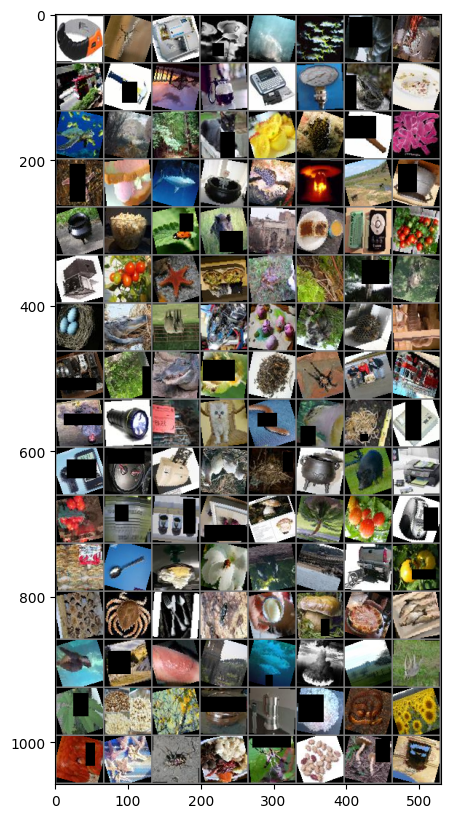

  saw spider printer spoon turtle  fish squash motor truck hammer bridge   pot printer gauge  frog icecream turtle turtle birch   cat tomato  worm hammer bacteria echinoderm icecream  fish   pot turtle  bomb elephant   pot   pot  corn beetle swine memorial bread battery tomato camera tomato echinoderm pizza  frog  frog  palm kangaroo  nest crocodilian elephant motor   egg monkey  nest elephant camera birch crocodilian  frog   tea spider  crab truck swine battery  crab   cat snake turtle  worm printer gauge gauge printer  nest  nest   pot swine antenna tomato acoustic acoustic  bean fungus  palm tomato printer  crab spoon icecream beetle monkey bridge motor tomato  nest  crab spoon beetle   egg fungus pizza  fish turtle truck bacteria memorial  fish  bomb memorial kangaroo birch  corn birch   pot   pot  corn snake flower snake echinoderm beetle spice spider  bean fungus acoustic


In [9]:
plt.figure(figsize = (20,10))
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % raw_train_set.classes[labels[j]] for j in range(BATCH_SIZE)))

In [10]:
def peek_class(class_name, dataset, img_num):
    cls_idx = raw_train_set.class_to_idx[class_name]
    data_indexes = [idx for idx, img_idx_tuple in enumerate(dataset.imgs) if img_idx_tuple[1] == cls_idx]
    class_set = Subset(dataset, data_indexes)
    class_loader = DataLoader(class_set, batch_size=img_num,
                              shuffle=True, num_workers=2)
    images, labels = next(iter(class_loader))
    plt.figure(figsize=(20,10))
    imshow(torchvision.utils.make_grid(images))
    print(' '.join('%5s' % raw_train_set.classes[labels[j]] for j in range(img_num)))

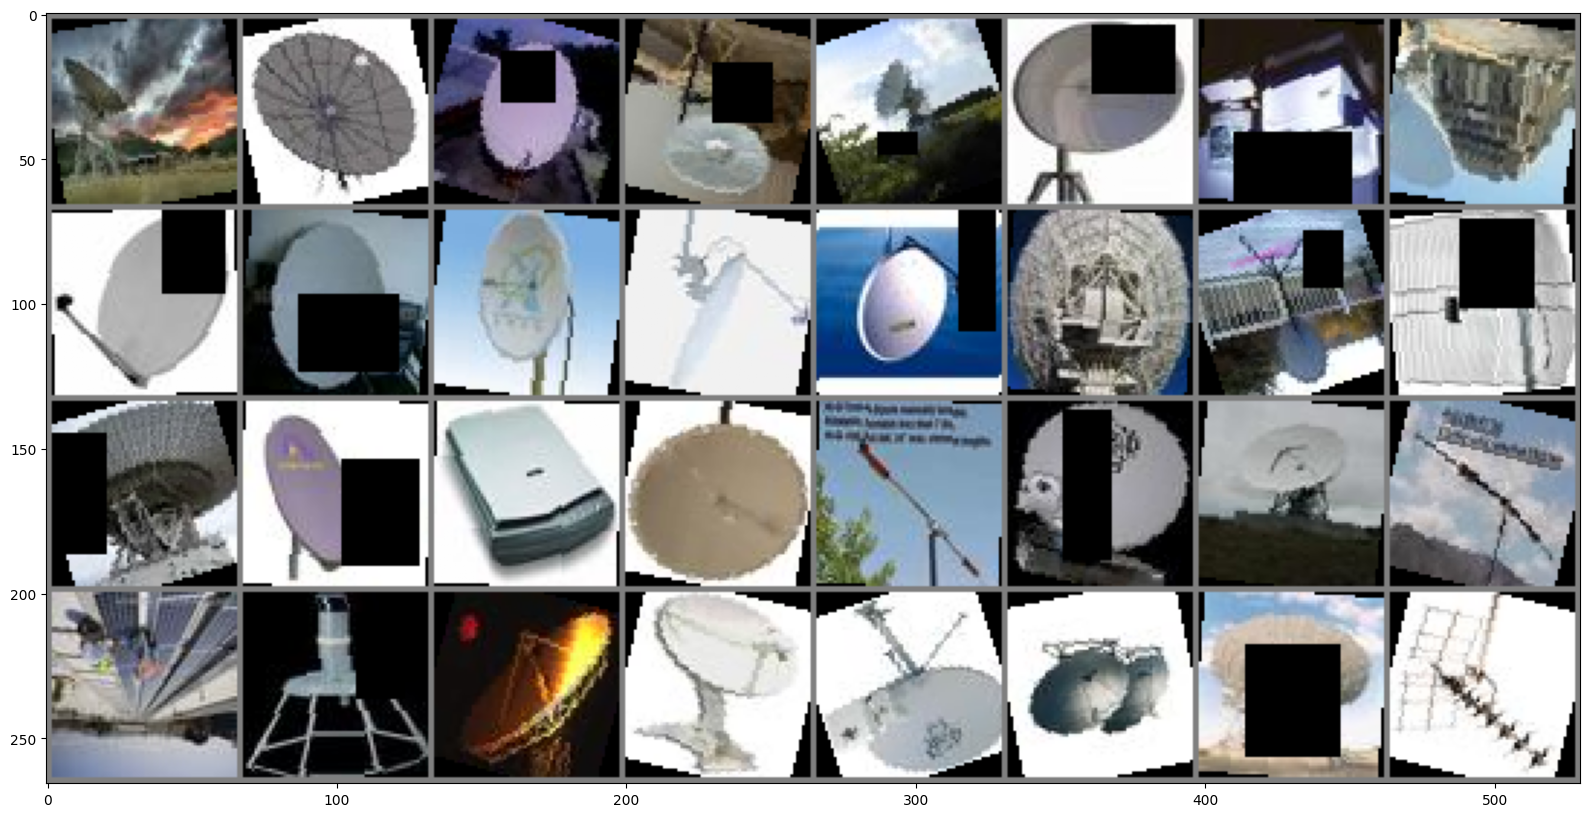

antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna antenna


In [11]:
peek_class("antenna", raw_train_set, 32)

### Sprawdzenie rozmiaru obrazu

In [12]:
images[0:1].size()

torch.Size([1, 3, 64, 64])

#### Na pierwszy rzut oka widać że niektóre przykłady nie mają sensu nawet dla człowieka, więc może się zdarzyc tak, że trening że część przykładów nie będzie się dawała dotrenować.

### Pętla treningowa

In [13]:
import os


def train(model, optimizer, criterion, epoch_num, train_loader, test_loader, dir_path="weights", model_name="model"):
    train_batch_num, test_batch_num = len(train_loader), len(test_loader)

    best_accuracy = 0

    train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = [], [], [], []
    for epoch in range(1, epoch_num + 1): 
        # print(f"[{epoch + 1}/{epoch_num}]")
        # train
        model.train()

        # train_progress_bar = tqdm(total=train_batch_num)
        batch_loss, batch_accuracy, batch_correct_sum, train_running_loss_sum, train_running_loss, train_running_accuracy, train_correct_sum, train_sample_sum = 0, 0, 0, 0, 0, 0, 0, 0
        epoch_loss, epoch_accuracy = 0, 0
        for batch_num, data in enumerate(train_loader, 1):
            inputs, labels = data
            train_sample_sum += len(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            train_running_loss_sum += batch_loss
            train_running_loss = train_running_loss_sum/batch_num
            epoch_loss += batch_loss


            _, predicted = torch.max(outputs, 1)
            batch_correct_sum = (predicted == labels).sum()
            train_correct_sum += batch_correct_sum
            train_running_accuracy = train_correct_sum/train_sample_sum
            batch_accuracy = batch_correct_sum/len(inputs)
            epoch_accuracy += batch_accuracy

            # train_progress_bar.update(1)
            # train_progress_bar.set_description(f"TRAINING: current batch loss = {batch_loss:.2f}, current batch accuracy = {batch_accuracy:.2f}, running loss = {train_running_loss:.2f}, running accuracy = {train_running_accuracy:.2f}")


        train_loss_list.append(epoch_loss/train_batch_num)
        train_accuracy_list.append(epoch_accuracy/train_batch_num)
        print(f"Epoch {epoch}: TRAINING: epoch loss = {epoch_loss/train_batch_num:.2f}, epoch accuracy = {epoch_accuracy/train_batch_num:.2f}")
        # eval
        model.eval()

        # test_progress_bar = tqdm(total=test_batch_num)
        batch_loss, batch_accuracy, batch_correct_sum, test_running_loss_sum, test_running_loss, test_running_accuracy, test_correct_sum, test_sample_sum = 0, 0, 0, 0, 0, 0, 0, 0
        epoch_loss, epoch_accuracy = 0, 0
        for batch_num, data in enumerate(test_loader, 1):
            inputs, labels = data
            test_sample_sum += len(inputs)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_loss = loss.item()
            test_running_loss_sum += batch_loss
            test_running_loss = test_running_loss_sum/batch_num
            epoch_loss += batch_loss

            _, predicted = torch.max(outputs, 1)
            batch_correct_sum = (predicted == labels).sum()
            test_correct_sum += batch_correct_sum
            test_running_accuracy = test_correct_sum/test_sample_sum
            batch_accuracy = batch_correct_sum/len(inputs)
            epoch_accuracy += batch_accuracy

            # test_progress_bar.set_description(f"VALIDATION: current batch loss = {batch_loss:.2f}, current batch accuracy = {batch_accuracy:.2f},\n running loss = {test_running_loss:.2f}, running accuracy = {test_running_accuracy:.2f}")
            # test_progress_bar.update(1)
        
        test_loss_list.append(epoch_loss/test_batch_num)
        test_accuracy_list.append(epoch_accuracy/test_batch_num)

        if epoch_accuracy/test_batch_num > best_accuracy:
            best_accuracy = epoch_accuracy/test_batch_num
            # include accuracy in the name of the model and epoch
            path_tp_save_model = os.path.join(dir_path, f"{model_name}_{best_accuracy:.2f}_{epoch}.pth")
            torch.save(model.state_dict(), path_tp_save_model)
            print(f"Model saved to {path_tp_save_model}")

        print(f"Epoch {epoch}: VALIDATION: epoch loss = {epoch_loss/test_batch_num:.2f}, epoch accuracy = {epoch_accuracy/test_batch_num:.2f}")
        print()
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

In [14]:
def check_class_accuracy(model, classes, data_loader):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        model.eval()
        
        checking_progress_bar = tqdm(total=len(data_loader))
        for data in data_loader:
            images, labels = data    
            images = images.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            checking_progress_bar.update(1)

    accuracy = {classname: correct_count/total_count for classname, correct_count, total_count in zip(classes, correct_pred.values(), total_pred.values())}
    return accuracy

In [19]:
# 64, 32, 16, 8 - out matrix sizes
# 32, 64, 64, 128 - num features
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self._num_classes = num_classes
        # input img 64*64*3

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        # (64 - 3(kernel_s) + 2*1(padding)) / 1(stride) + 1(subtract_incl) = 64
        self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # 64 / 2 = 32

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        # (32 - 3 + 2*1) / 1 + 1  = 32
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # 32 / 2 = 16

        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        # (16 - 3 + 2*1) / 1 + 1  = 16
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # (16 - 3 + 2*1) / 1 + 1  = 16
        self.bn4 = nn.BatchNorm2d(32)
        self.pool3_4 = nn.MaxPool2d(kernel_size=2)
        # 16 / 2 = 8

        self.fc1 = nn.Linear(32*8*8, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.act = torch.nn.ReLU()
        self.dropout = nn.Dropout2d(0.4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(self.act(x))

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(self.act(x))
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act(self.conv3(x))
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.pool3_4(self.act(x))

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(self.act(x))
        return x


In [11]:
num_classes = len(raw_train_set.class_to_idx)

In [18]:
model = MyCNN(num_classes).to(device)



# model = models.resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

NameError: name 'MyCNN' is not defined

In [17]:
# model = models.vgg11(pretrained=True).to(device)
model

MyCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): L

In [18]:
train(model, optimizer, criterion, 20, train_loader, test_loader)
# torch.save(model.state_dict(), "resnet50_20epochs.pth")

/home/wojtek/anaconda3/envs/ssne/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [ ]:
pass
# acc_dict = check_class_accuracy(model, raw_train_set.classes, test_loader)
# for name, acc in sorted(list(acc_dict.items()), key=lambda x: x[1]):
    # print(f"{name}: {acc:.2f}")

In [ ]:
# 64, 32, 16, 8 - out matrix sizes
# 32, 64, 64, 128 - num features
class MyCNN2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self._num_classes = num_classes
        # input img 64*64*3

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),     
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32*8*8, 128),
            nn.Dropout2d(0.4),
            nn.Linear(128, num_classes)
        )


    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [ ]:
num_classes = len(raw_train_set.class_to_idx)
model = MyCNN2(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train(model, optimizer, criterion, 20, train_loader, test_loader)

In [ ]:
# torch.save(model.state_dict(), "my_cnn2_20epochs.pth")

In [ ]:
num_classes = len(raw_train_set.class_to_idx)
model = MyCNN2(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 50, train_loader, test_loader)
torch.save(model.state_dict(), "my_cnn2_50epochs.pth")
# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="train")
plt.plot(test_loss_list, label="test")
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label="train")
plt.plot(test_accuracy_list, label="test")
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
class MyCNN3(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [ ]:
num_classes = len(raw_train_set.class_to_idx)
model = MyCNN3(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 50, train_loader, test_loader )
torch.save(model.state_dict(), "my_cnn3_50epochs_aug.pth")
# detach to cpu
train_loss_list = [x.cpu().detach().numpy() for x in train_loss_list]
train_accuracy_list = [x.cpu().detach().numpy() for x in train_accuracy_list]
test_loss_list = [x.cpu().detach().numpy() for x in test_loss_list]
test_accuracy_list = [x.cpu().detach().numpy() for x in test_accuracy_list]

# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="train")
plt.plot(test_loss_list, label="test")
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label="train")
plt.plot(test_accuracy_list, label="test")
plt.legend()
plt.title("Accuracy")
plt.show()

In [14]:
class MyCNN4(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [29]:
num_classes = len(raw_train_set.class_to_idx)
model = MyCNN4(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 50, train_loader, test_loader )
torch.save(model.state_dict(), "my_cnn4_50epochs_aug.pth")

Epoch 1: TRAINING: epoch loss = 3.52, epoch accuracy = 0.09
Model saved to weights/model_0.13_1.pth
Epoch 1: VALIDATION: epoch loss = 3.31, epoch accuracy = 0.13

Epoch 2: TRAINING: epoch loss = 3.28, epoch accuracy = 0.13
Model saved to weights/model_0.19_2.pth
Epoch 2: VALIDATION: epoch loss = 3.04, epoch accuracy = 0.19

Epoch 3: TRAINING: epoch loss = 3.13, epoch accuracy = 0.17
Model saved to weights/model_0.22_3.pth
Epoch 3: VALIDATION: epoch loss = 2.92, epoch accuracy = 0.22

Epoch 4: TRAINING: epoch loss = 3.00, epoch accuracy = 0.20
Model saved to weights/model_0.26_4.pth
Epoch 4: VALIDATION: epoch loss = 2.81, epoch accuracy = 0.26

Epoch 5: TRAINING: epoch loss = 2.90, epoch accuracy = 0.22
Model saved to weights/model_0.27_5.pth
Epoch 5: VALIDATION: epoch loss = 2.74, epoch accuracy = 0.27

Epoch 6: TRAINING: epoch loss = 2.81, epoch accuracy = 0.24
Model saved to weights/model_0.29_6.pth
Epoch 6: VALIDATION: epoch loss = 2.63, epoch accuracy = 0.29

Epoch 7: TRAINING: epo

In [31]:
train(model, optimizer, criterion, 20, train_loader, test_loader, model_name="my_cnn4_50_epoch_fine_tune.pth")

Epoch 1: TRAINING: epoch loss = 1.65, epoch accuracy = 0.54
Model saved to weights/my_cnn4_50_epoch_fine_tune.pth_0.53_1.pth
Epoch 1: VALIDATION: epoch loss = 1.70, epoch accuracy = 0.53

Epoch 2: TRAINING: epoch loss = 1.64, epoch accuracy = 0.55
Model saved to weights/my_cnn4_50_epoch_fine_tune.pth_0.54_2.pth
Epoch 2: VALIDATION: epoch loss = 1.67, epoch accuracy = 0.54

Epoch 3: TRAINING: epoch loss = 1.64, epoch accuracy = 0.55
Epoch 3: VALIDATION: epoch loss = 1.68, epoch accuracy = 0.54

Epoch 4: TRAINING: epoch loss = 1.62, epoch accuracy = 0.55
Epoch 4: VALIDATION: epoch loss = 1.68, epoch accuracy = 0.54

Epoch 5: TRAINING: epoch loss = 1.62, epoch accuracy = 0.55
Epoch 5: VALIDATION: epoch loss = 1.67, epoch accuracy = 0.54

Epoch 6: TRAINING: epoch loss = 1.61, epoch accuracy = 0.55
Model saved to weights/my_cnn4_50_epoch_fine_tune.pth_0.54_6.pth
Epoch 6: VALIDATION: epoch loss = 1.66, epoch accuracy = 0.54

Epoch 7: TRAINING: epoch loss = 1.60, epoch accuracy = 0.56
Model s

([1.6543307025289795,
  1.6351500210874526,
  1.6351655650268666,
  1.6239199869862053,
  1.617435250654411,
  1.609561675905965,
  1.595071523029445,
  1.6055348042784066,
  1.5851041832550035,
  1.5827628421696907,
  1.5748157451460019,
  1.5573194528880872,
  1.5541343920460198,
  1.54223461679019,
  1.5540730295510128,
  1.5509113975531825,
  1.5268402995301678,
  1.518086853347543,
  1.5183046517484633,
  1.516558369794039],
 [tensor(0.5413, device='cuda:0'),
  tensor(0.5472, device='cuda:0'),
  tensor(0.5455, device='cuda:0'),
  tensor(0.5490, device='cuda:0'),
  tensor(0.5504, device='cuda:0'),
  tensor(0.5544, device='cuda:0'),
  tensor(0.5584, device='cuda:0'),
  tensor(0.5530, device='cuda:0'),
  tensor(0.5580, device='cuda:0'),
  tensor(0.5605, device='cuda:0'),
  tensor(0.5616, device='cuda:0'),
  tensor(0.5667, device='cuda:0'),
  tensor(0.5696, device='cuda:0'),
  tensor(0.5694, device='cuda:0'),
  tensor(0.5679, device='cuda:0'),
  tensor(0.5686, device='cuda:0'),
  tens

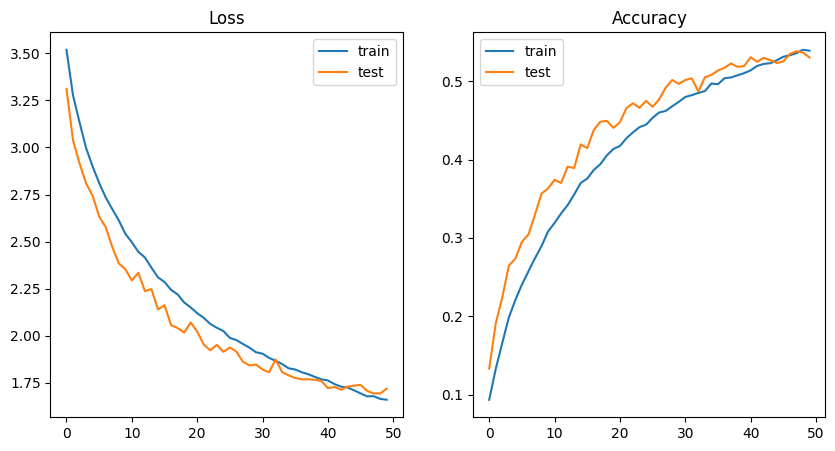

In [33]:
# train_loss_list = [x.cpu().detach().numpy() for x in train_loss_list]
train_accuracy_list = [x.cpu().detach().numpy() for x in train_accuracy_list]
# test_loss_list = [x.cpu().detach().numpy() for x in test_loss_list]
test_accuracy_list = [x.cpu().detach().numpy() for x in test_accuracy_list]
# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="train")
plt.plot(test_loss_list, label="test")
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label="train")
plt.plot(test_accuracy_list, label="test")
plt.legend()
plt.title("Accuracy")
plt.show()

- plot for first 50 epochs, later 20 epochs losses were only printed, not plotted

In [34]:
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, optimizer, criterion, 20, train_loader, test_loader )
torch.save(model.state_dict(), "my_cnn4_70epochs_aug.pth")

Epoch 1: TRAINING: epoch loss = 1.50, epoch accuracy = 0.58
Model saved to weights/model_0.55_1.pth
Epoch 1: VALIDATION: epoch loss = 1.65, epoch accuracy = 0.55

Epoch 2: TRAINING: epoch loss = 1.51, epoch accuracy = 0.58
Epoch 2: VALIDATION: epoch loss = 1.70, epoch accuracy = 0.54

Epoch 3: TRAINING: epoch loss = 1.51, epoch accuracy = 0.58
Model saved to weights/model_0.56_3.pth
Epoch 3: VALIDATION: epoch loss = 1.61, epoch accuracy = 0.56

Epoch 4: TRAINING: epoch loss = 1.53, epoch accuracy = 0.58
Epoch 4: VALIDATION: epoch loss = 1.63, epoch accuracy = 0.56

Epoch 5: TRAINING: epoch loss = 1.47, epoch accuracy = 0.59
Model saved to weights/model_0.56_5.pth
Epoch 5: VALIDATION: epoch loss = 1.61, epoch accuracy = 0.56

Epoch 6: TRAINING: epoch loss = 1.48, epoch accuracy = 0.59
Epoch 6: VALIDATION: epoch loss = 1.61, epoch accuracy = 0.56

Epoch 7: TRAINING: epoch loss = 1.47, epoch accuracy = 0.59
Epoch 7: VALIDATION: epoch loss = 1.63, epoch accuracy = 0.56

Epoch 8: TRAINING: 

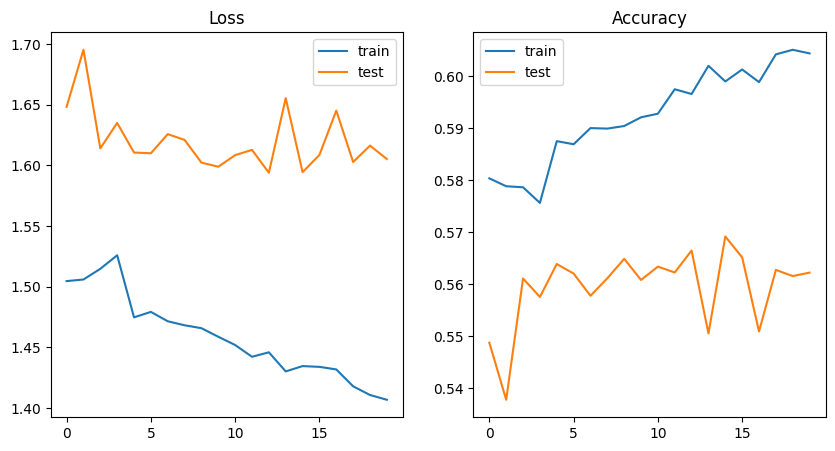

In [35]:
# train_loss_list = [x.cpu().detach().numpy() for x in train_loss_list]
train_accuracy_list = [x.cpu().detach().numpy() for x in train_accuracy_list]
# test_loss_list = [x.cpu().detach().numpy() for x in test_loss_list]
test_accuracy_list = [x.cpu().detach().numpy() for x in test_accuracy_list]
# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="train")
plt.plot(test_loss_list, label="test")
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label="train")
plt.plot(test_accuracy_list, label="test")
plt.legend()
plt.title("Accuracy")
plt.show()

In [15]:
# load model from weights
production_model = MyCNN4(num_classes).to(device)
production_model.load_state_dict(torch.load("weights/model_0.57_15.pth"))
production_model.eval()


MyCNN4(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [16]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


#### sanity check

data/test_all/23033215093141313.JPEG -> Class 22 -> flower


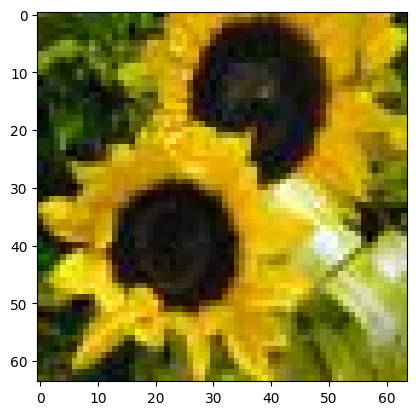

In [22]:
from PIL import Image
import os

folder_path = 'data/test_all'


def predict_image(img_path):
    image = Image.open(img_path)
    plt.imshow(image)
    image_tensor = transform(image).to(device)
    image_tensor = image_tensor.unsqueeze(0)
    output = production_model(image_tensor)
    # translate indeces to classes with raw_train_set.class_to_idx
    label = list(raw_train_set.class_to_idx.keys())[list(raw_train_set.class_to_idx.values()).index(torch.argmax(output).item())]
    predicted_class = torch.argmax(output).item()
    print(f'{img_path} -> Class {predicted_class} -> {label}')

path0 = os.path.join(folder_path, os.listdir(folder_path)[0])
predict_image(path0)

data/test_all/05699355184448307.JPEG -> Class 6 -> bicycle


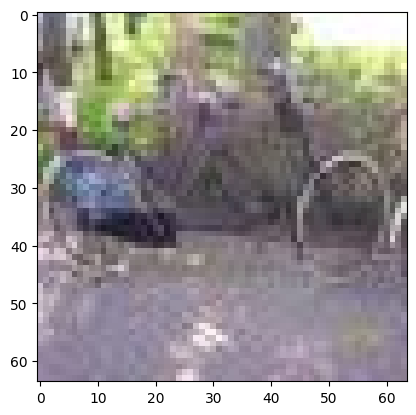

In [24]:
path22 = os.path.join(folder_path, os.listdir(folder_path)[2])
predict_image(path22)

In [41]:
def predict_image_raw(img_path):
    image = Image.open(img_path)
    image_tensor = transform(image).to(device)
    image_tensor = image_tensor.unsqueeze(0)
    output = production_model(image_tensor)
    label = list(raw_train_set.class_to_idx.keys())[list(raw_train_set.class_to_idx.values()).index(torch.argmax(output).item())]
    class_num = torch.argmax(output).item()
    filename = os.path.basename(img_path)
    return f"{filename},{class_num}"

test for ten images

In [30]:

import os
folder_path = 'data/test_all'
output = []
counter = 0
for filename in os.listdir(folder_path):
    path = os.path.join(folder_path, filename)
    output.append(predict_image_raw(path))
    counter += 1
    if counter > 10:
        break
    if counter % 100 == 0:
        print(f"{counter} images predicted")

In [33]:
output
# write to file csv
with open('submission.csv', 'w') as f:
    for item in output:
        f.write(f"{item}\n")

In [42]:
output = []
for filename in os.listdir(folder_path):
    path = os.path.join(folder_path, filename)
    try:
        output.append(predict_image_raw(path))
    except:
        print(f"error with {path}")
    if counter % 100 == 0:
        print(f"{counter} images predicted")
with open('submission.csv', 'w') as f:
    for item in output:
        f.write(f"{item}\n")

error with data/test_all/7804703531389453.JPEG
error with data/test_all/2984146836597449.JPEG
error with data/test_all/47608197574699906.JPEG
error with data/test_all/1725393189203981.JPEG
error with data/test_all/39408368229947555.JPEG
error with data/test_all/5860692216367205.JPEG
error with data/test_all/9798848788780467.JPEG
error with data/test_all/276696118643762.JPEG
error with data/test_all/8417344828805355.JPEG
error with data/test_all/8631777506453079.JPEG
error with data/test_all/9593740326042175.JPEG
error with data/test_all/7166160567407397.JPEG
error with data/test_all/8128976580480574.JPEG
error with data/test_all/6081934414117315.JPEG
error with data/test_all/1995625348177238.JPEG
error with data/test_all/4701570150270994.JPEG
error with data/test_all/5569749561561889.JPEG
error with data/test_all/45864977320078504.JPEG
error with data/test_all/7384986918317399.JPEG
error with data/test_all/31930688721013345.JPEG
error with data/test_all/21134705787779395.JPEG
error wit